# Problem 5: Object Segmentation via FastSAM
---
**Robotics and Mechatronics - MP4** | *Group 11*

[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fast Segment Anything Model (FastSAM)
The Fast Segment Anything Model (FastSAM) is a CNN Segment Anything Model trained by only 2% of the SA-1B dataset published by SAM authors.

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/CASIA-IVA-Lab/FastSAM)
[![arXiv](https://img.shields.io/badge/arXiv-2306.12156-b31b1b.svg)](https://arxiv.org/pdf/2306.12156.pdf)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/yHNPyqazYYU)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-fastsam)



To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install FastSAM, SAM, and other dependencies

In [2]:
%cd {HOME}

# install FastSAM
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
!pip -q install -r FastSAM/requirements.txt
# install CLIP
!pip -q install git+https://github.com/openai/CLIP.git
# install SAM
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
# install other dependencies
!pip -q install roboflow supervision jupyter_bbox_widget

/content
fatal: destination path 'FastSAM' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


## Download FastSAM and SAM weights

In [3]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P {HOME}/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!ls -lh {HOME}/weights

total 5.1G
-rw-r--r-- 1 root root 139M Jun 20  2023 FastSAM.pt
-rw-r--r-- 1 root root 139M Jun 20  2023 FastSAM.pt.1
-rw-r--r-- 1 root root 2.4G Apr  4  2023 sam_vit_h_4b8939.pth
-rw-r--r-- 1 root root 2.4G Apr  4  2023 sam_vit_h_4b8939.pth.1


In [4]:
FAST_SAM_CHECKPOINT_PATH = f"{HOME}/weights/FastSAM.pt"
SAM_SAM_CHECKPOINT_PATH = f"{HOME}/weights/sam_vit_h_4b8939.pth"

## Imports

Note that `FastSAM` code is not distributed via `pip`*italicized text*. Make sure to run code below from `{HOME}/FastSAM` directory.

In [6]:
%cd {HOME}/FastSAM

import os
import cv2
import torch
import roboflow
import base64
import supervision as sv
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
from roboflow import Roboflow
from fastsam import FastSAM, FastSAMPrompt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

/content/FastSAM


## Load FastSAM

In [7]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE = {DEVICE}")
fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

DEVICE = cpu


In [8]:
os.makedirs(f"{HOME}/output", exist_ok=True)

## Generate mask with FastSAM

In [9]:
# Convert masks to boolean (True/False)
def masks_to_bool(masks):
    if type(masks) == np.ndarray:
        return masks.astype(bool)
    return masks.cpu().numpy().astype(bool)

In [10]:
def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

## FastSAM box prompt inference

In [11]:
# helper function that loads an image before adding it to the widget

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

## Load pre-configured boundary boxes

In [12]:
# drive.mount('/content/drive')
saved_dir = '/content/drive/My Drive/YOLOv8_training/boxes/box_list.pt'
box_list = torch.load(saved_dir)

## Load test images

In [13]:
# Define the path to the shared folder
shared_folder_path = f'/content/drive/My Drive/MP4/MP4/test images'

# List the contents of the shared folder
print(os.listdir(shared_folder_path))
test_images = []

for image in os.listdir(shared_folder_path):
    image_path = os.path.join(shared_folder_path, image)
    test_images.append(image_path)


['IMG_E1392.JPG', 'IMG_E1367.JPG', 'IMG_E1370.JPG', 'IMG_E1342.JPG', 'IMG_E1397.JPG', 'IMG_3236.JPG', 'IMG_3243.JPG', 'IMG_1246.JPG', 'IMG_3025.JPG', 'WIN_20230917_13_32_27_Pro.jpg']


## FastSAM inference

* `retina_masks=True` determines whether the model uses retina masks for generating segmentation masks.
* `imgsz=1024` sets the input image size to 1024x1024 pixels for processing by the model.
* `conf=0.5` sets the minimum confidence threshold for object detection.
* `iou=0.6` sets the minimum intersection over union threshold for non-maximum suppression to filter out duplicate detections.


image 1/1 /content/drive/My Drive/MP4/MP4/test images/IMG_E1392.JPG: 1024x1024 16 objects, 15211.1ms
Speed: 14.4ms preprocess, 15211.1ms inference, 4948.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/drive/My Drive/MP4/MP4/test images/IMG_E1367.JPG: 1024x1024 8 objects, 14920.1ms
Speed: 11.9ms preprocess, 14920.1ms inference, 1388.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/drive/My Drive/MP4/MP4/test images/IMG_E1370.JPG: 1024x1024 8 objects, 14809.7ms
Speed: 13.5ms preprocess, 14809.7ms inference, 2252.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/drive/My Drive/MP4/MP4/test images/IMG_E1342.JPG: 1024x1024 11 objects, 15881.0ms
Speed: 19.8ms preprocess, 15881.0ms inference, 2199.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/drive/My Drive/MP4/MP4/test images/IMG_E1397.JPG: 1024x1024 11 objects, 15608.5ms
Speed: 13.3ms preprocess, 15608.5ms inference, 2132.3ms postprocess 

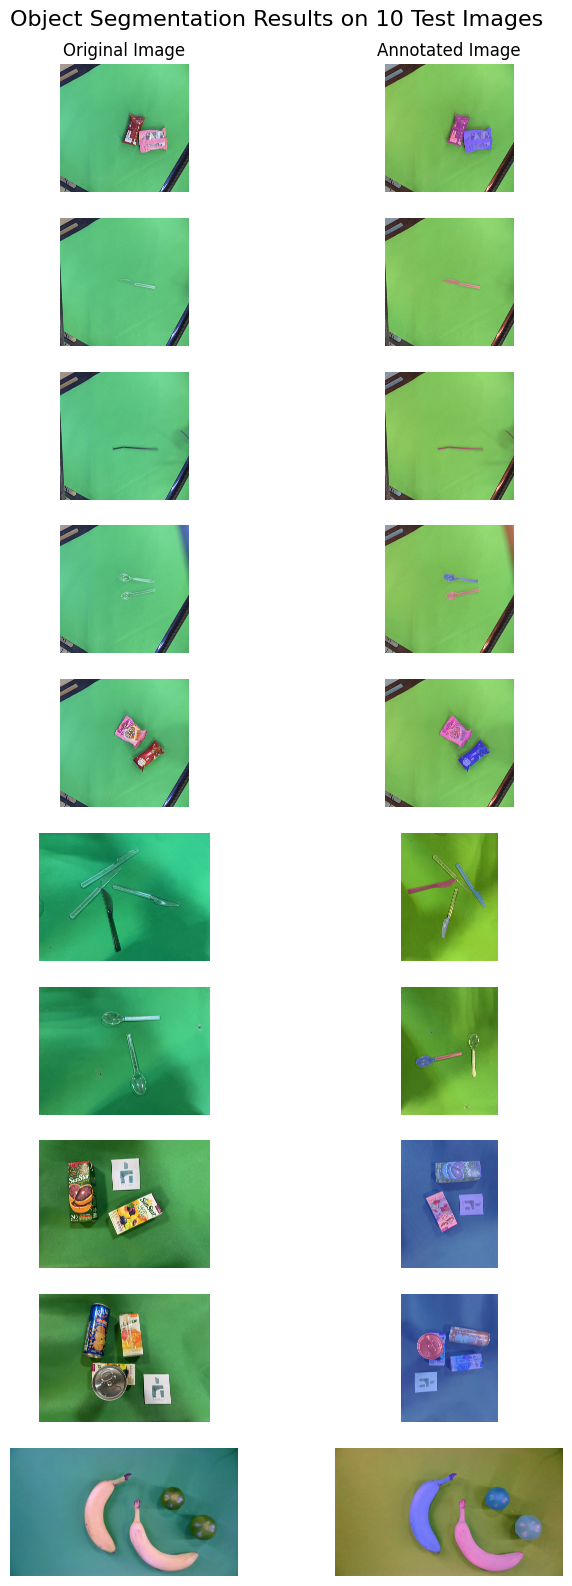

In [18]:
# Create subplots
fig, axes = plt.subplots(len(test_images), 2, figsize=(8, 18))  # Adjust figsize as needed

# Adjust wspace and hspace to control spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2, top=0.95)
width, height = 720, 720

fig.suptitle('Object Segmentation Results on 10 Test Images', fontsize=16)

for i in range(len(test_images)):

    IMAGE_PATH = test_images[i]
    boxes = box_list[i]
    results = fast_sam(
        source=IMAGE_PATH,
        device=DEVICE,
        retina_masks=True,
        imgsz=1024,
        conf=0.5,
        iou=0.6)
    prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
    masks = []
    for box in boxes:
        b = [float(box[0]), float(box[1]), float(box[2]), float(box[3])]
        mask = prompt_process.box_prompt(bbox=b)
        masks.append(mask)

    masks = np.concatenate(masks, axis=0)
    masks = masks_to_bool(masks)
    annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
    #   sv.plot_image(image=annotated_image, size=(8, 8))


    img = Image.open(IMAGE_PATH)
    # img = img.resize((width, height))
    # annotated_image = annotated_image.resize((width, height))
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')  # Turn off axis labels
    axes[i, 1].imshow(annotated_image)
    axes[i, 1].axis('off')  # Turn off axis labels

# Add a label above the image
axes[0, 0].set_title('Original Image', fontsize=12)
axes[0, 1].set_title('Annotated Image', fontsize=12)

# plt.tight_layout()
plt.show()
